# Multi-Resolution Sampling Comparison Test

This notebook tests the differences between multi-resolution sampling (with padding and attention mask) and original sampling methods using two test images with different resolutions.

## Test Images:
1. Image 1: 300x450 (portrait)
2. Image 2: 630x945 (portrait)

## Prompt: "把头发改成蓝色" (Change hair to blue)


In [1]:
# Setup paths and imports
package = "../../"
import sys
import os
package = os.path.abspath(package)
sys.path.append(package)


In [2]:
import numpy as np
import torch
import logging
import sys
import os
import pytest
import glob
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import json
from src.trainer.flux_kontext_trainer import FluxKontextLoraTrainer
from src.data.config import load_config_from_yaml
from src.data.dataset import loader
from diffusers.utils import load_image


/home/lilong/.local/envs/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [3]:
# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(name)s: %(message)s",
    handlers=[logging.StreamHandler(sys.stdout)],
    force=True,
)
logger = logging.getLogger(__name__)
logger.info("Multi-resolution sampling test started")


2025-10-15 18:06:19,646 | INFO | __main__: Multi-resolution sampling test started


## 1. Load Test Images


In [4]:
# Load configuration first to get test parameters
config_path = "../../tests/test_configs/test_example_fluxkontext_multiresolution.yaml"
config = load_config_from_yaml(config_path)

# Get test image URLs from config or use defaults
test_params = getattr(config, 'test', {})
config_urls = test_params.get('test_images', None)

if config_urls and len(config_urls) >= 2:
    image_urls = config_urls
    print(f"Using image URLs from config: {image_urls}")
else:
    # Default image URLs
    image_urls = [
        "https://image.tmdb.org/t/p/w300/cn32HNmbpBQqbAnoPBQq2sj3ax5.jpg",
        "https://n.sinaimg.cn/ent/transform/775/w630h945/20201127/cee0-kentcvx8062290.jpg"
    ]
    print(f"Using default image URLs: {image_urls}")

# Load images
test_images = []
for i, url in enumerate(image_urls):
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content)).convert('RGB')
        test_images.append(img)
        print(f"Image {i+1}: {img.size} - {url}")
    except Exception as e:
        print(f"Failed to load image {i+1}: {e}")
        # Create a placeholder image if loading fails
        test_images.append(Image.new('RGB', (300, 450), color='red'))

print(f"\nLoaded {len(test_images)} test images")


Using default image URLs: ['https://image.tmdb.org/t/p/w300/cn32HNmbpBQqbAnoPBQq2sj3ax5.jpg', 'https://n.sinaimg.cn/ent/transform/775/w630h945/20201127/cee0-kentcvx8062290.jpg']
Image 1: (300, 450) - https://image.tmdb.org/t/p/w300/cn32HNmbpBQqbAnoPBQq2sj3ax5.jpg
Image 2: (630, 945) - https://n.sinaimg.cn/ent/transform/775/w630h945/20201127/cee0-kentcvx8062290.jpg

Loaded 2 test images


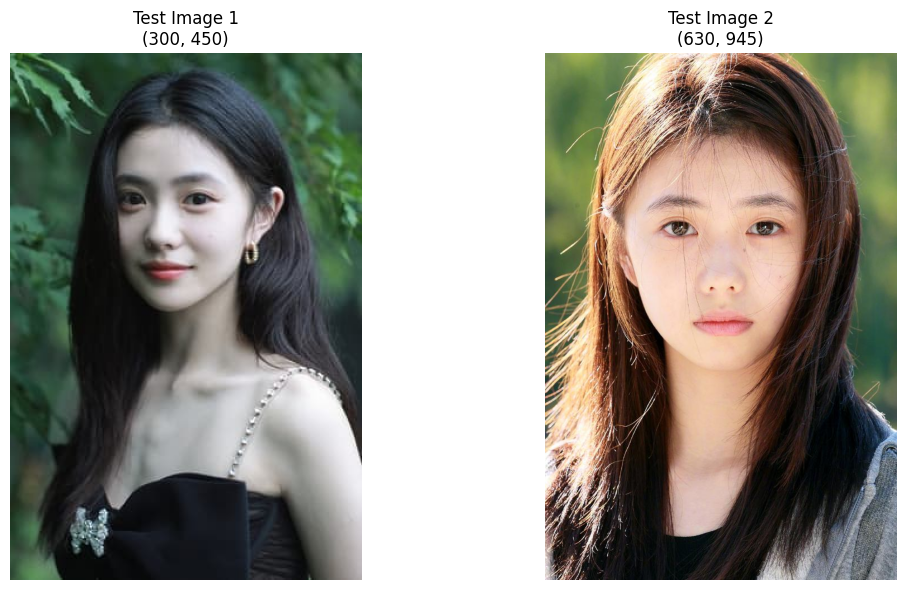

In [5]:
# Display test images
fig, axes = plt.subplots(1, len(test_images), figsize=(12, 6))
if len(test_images) == 1:
    axes = [axes]

for i, img in enumerate(test_images):
    axes[i].imshow(img)
    axes[i].set_title(f"Test Image {i+1}\n{img.size}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


## 2. Setup Configuration and Trainer


In [6]:
# Verify multi-resolution support (config already loaded)
if hasattr(config.data.init_args.processor.init_args, 'multi_resolutions'):
    multi_res = config.data.init_args.processor.init_args.multi_resolutions
    print(f"Multi-resolution support enabled: {multi_res}")
else:
    print("Warning: Multi-resolution support not found in config")

print(f"Model: {config.model.pretrained_model_name_or_path}")
print(f"Batch size: {config.data.batch_size}")
print(f"Output directory: {config.logging.output_dir}")


Multi-resolution support enabled: [102400, 262144, 409600]
Model: lrzjason/flux-kontext-nf4
Batch size: 2
Output directory: /tmp/image_edit_lora


In [7]:
# Initialize trainer
trainer = FluxKontextLoraTrainer(config)
print("Trainer initialized")


2025-10-15 18:06:20,698 | INFO | src.trainer.base_trainer: Batch Size: 2
2025-10-15 18:06:20,699 | INFO | src.trainer.base_trainer: Use Cache: True
2025-10-15 18:06:20,700 | INFO | root: Multi-resolution mode: simple (shared candidates: [102400, 262144, 409600])
2025-10-15 18:06:20,700 | INFO | root: ImageProcessor initialized with target_size: Nonecontrols_size: Nonetarget_pixels: Nonecontrols_pixels: None
Trainer initialized


In [8]:
# Load model
print("Loading model...")
trainer.load_model()
print("Model loaded successfully")


Loading model...
2025-10-15 18:06:20,704 | INFO | root: Loading FluxKontextPipeline and separating components...
2025-10-15 18:06:20,704 | INFO | src.models.flux_kontext_loader: Loading Flux Kontext VAE from lrzjason/flux-kontext-nf4
configs {'_class_name': 'AutoencoderKL', '_diffusers_version': '0.34.0.dev0', '_name_or_path': '/raid/.cache/huggingface/models--black-forest-labs--FLUX.1-dev/snapshots/0ef5fff789c832c5c7f4e127f94c8b54bbcced44/vae', 'act_fn': 'silu', 'block_out_channels': [128, 256, 512, 512], 'down_block_types': ['DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D'], 'force_upcast': True, 'in_channels': 3, 'latent_channels': 16, 'latents_mean': None, 'latents_std': None, 'layers_per_block': 2, 'mid_block_add_attention': True, 'norm_num_groups': 32, 'out_channels': 3, 'sample_size': 1024, 'scaling_factor': 0.3611, 'shift_factor': 0.1159, 'up_block_types': ['UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D'], 'us

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 61.86it/s]


configs {'_class_name': 'FluxTransformer2DModel', '_diffusers_version': '0.33.1', '_name_or_path': 'F:/T2ITrainer/flux_models/kontext_full/', 'attention_head_dim': 128, 'axes_dims_rope': [16, 56, 56], 'guidance_embeds': True, 'in_channels': 64, 'joint_attention_dim': 4096, 'num_attention_heads': 24, 'num_layers': 19, 'num_single_layers': 38, 'out_channels': None, 'patch_size': 1, 'pooled_projection_dim': 768, 'quantization_config': {'_load_in_4bit': True, '_load_in_8bit': False, 'bnb_4bit_compute_dtype': 'float32', 'bnb_4bit_quant_storage': 'uint8', 'bnb_4bit_quant_type': 'nf4', 'bnb_4bit_use_double_quant': False, 'llm_int8_enable_fp32_cpu_offload': False, 'llm_int8_has_fp16_weight': False, 'llm_int8_skip_modules': None, 'llm_int8_threshold': 6.0, 'load_in_4bit': True, 'load_in_8bit': False, 'quant_method': 'bitsandbytes'}}
patch_size 1
in_channels 64
out_channels None
num_layers 19
num_single_layers 38
attention_head_dim 128
num_attention_heads 24
joint_attention_dim 4096
pooled_proje

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


2025-10-15 18:06:25,782 | INFO | src.models.flux_kontext_loader: Loading Flux Kontext scheduler from lrzjason/flux-kontext-nf4


Loading pipeline components...:  29%|██▊       | 2/7 [00:00<00:00, 19.95it/s]

configs {'_class_name': 'FluxTransformer2DModel', '_diffusers_version': '0.33.1', '_name_or_path': 'F:/T2ITrainer/flux_models/kontext_full/', 'attention_head_dim': 128, 'axes_dims_rope': [16, 56, 56], 'guidance_embeds': True, 'in_channels': 64, 'joint_attention_dim': 4096, 'num_attention_heads': 24, 'num_layers': 19, 'num_single_layers': 38, 'out_channels': None, 'patch_size': 1, 'pooled_projection_dim': 768, 'quantization_config': {'_load_in_4bit': True, '_load_in_8bit': False, 'bnb_4bit_compute_dtype': 'float32', 'bnb_4bit_quant_storage': 'uint8', 'bnb_4bit_quant_type': 'nf4', 'bnb_4bit_use_double_quant': False, 'llm_int8_enable_fp32_cpu_offload': False, 'llm_int8_has_fp16_weight': False, 'llm_int8_skip_modules': None, 'llm_int8_threshold': 6.0, 'load_in_4bit': True, 'load_in_8bit': False, 'quant_method': 'bitsandbytes'}}
guidance_embeds: True


Loading pipeline components...:  57%|█████▋    | 4/7 [00:02<00:01,  1.71it/s]

configs {'_class_name': 'AutoencoderKL', '_diffusers_version': '0.34.0.dev0', '_name_or_path': '/raid/.cache/huggingface/models--black-forest-labs--FLUX.1-dev/snapshots/0ef5fff789c832c5c7f4e127f94c8b54bbcced44/vae', 'act_fn': 'silu', 'block_out_channels': [128, 256, 512, 512], 'down_block_types': ['DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D'], 'force_upcast': True, 'in_channels': 3, 'latent_channels': 16, 'latents_mean': None, 'latents_std': None, 'layers_per_block': 2, 'mid_block_add_attention': True, 'norm_num_groups': 32, 'out_channels': 3, 'sample_size': 1024, 'scaling_factor': 0.3611, 'shift_factor': 0.1159, 'up_block_types': ['UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D'], 'use_post_quant_conv': False, 'use_quant_conv': False}


Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]

2025-10-15 18:06:28,668 | INFO | src.models.flux_kontext_loader: Successfully loaded Flux Kontext scheduler
2025-10-15 18:06:28,673 | INFO | root: Components loaded successfully. VAE scale factor: 8
Model loaded successfully


In [9]:
# Setup for prediction
print("Setting up model for prediction...")
trainer.setup_model_device_train_mode(stage="predict")
print("Model ready for prediction")


Setting up model for prediction...
Model ready for prediction


## 3. Prepare Test Data


In [10]:
# Get test prompts from config or use defaults
test_params = getattr(config, 'test', {})
config_prompts = test_params.get('test_prompts', None)

if config_prompts and len(config_prompts) >= len(test_images):
    test_prompts = config_prompts[:len(test_images)]
    print(f"Using prompts from config: {test_prompts}")
else:
    # Default prompts (English)
    test_prompts = [
        "Change hair color to blue",
        "Change hair color to blue"
    ]
    print(f"Using default prompts: {test_prompts}")

# No control images for this test
test_controls = [[] for _ in range(len(test_images))]

print(f"Test prompts: {test_prompts}")
print(f"Number of control images per sample: {[len(controls) for controls in test_controls]}")


Using default prompts: ['Change hair color to blue', 'Change hair color to blue']
Test prompts: ['Change hair color to blue', 'Change hair color to blue']
Number of control images per sample: [0, 0]


## 4. Test Normal Sampling First

Before testing multi-resolution sampling, let's first test normal sampling to ensure everything works correctly.


In [11]:
# # Test normal sampling using predict method (process each sample individually)
# print("Testing normal sampling with predict method...")
# print("Processing each sample individually...\n")

# normal_results = []

# for i, (img, prompt) in enumerate(zip(test_images, test_prompts)):
#     print(f"Processing sample {i+1}/{len(test_images)}...")
#     print(f"  Image size: {img.size}")
#     print(f"  Prompt: {prompt}")

#     try:
#         # Use predict method for single sample
#         result = trainer.predict(
#             prompt_image=img,
#             prompt=prompt,
#             num_inference_steps=20,
#             guidance_scale=3.5,
#         )

#         normal_results.append(result[0])
#         print(f"  ✅ Sample {i+1} completed successfully!")

#         # Save result
#         result_path = f"./normal_sampling_sample_{i+1}.png"
#         result[0].save(result_path)
#         print(f"  Saved to: {result_path}\n")

#     except Exception as e:
#         print(f"  ❌ Sample {i+1} failed: {e}")
#         import traceback
#         traceback.print_exc()
#         normal_results.append(None)

# # Display results
# if any(normal_results):
#     print(f"\n✅ Normal sampling completed! Generated {sum(1 for r in normal_results if r is not None)}/{len(test_images)} images")

#     # Display all results
#     fig, axes = plt.subplots(len(test_images), 2, figsize=(12, 6*len(test_images)))
#     if len(test_images) == 1:
#         axes = [axes]

#     for i, (img, result) in enumerate(zip(test_images, normal_results)):
#         # Original image
#         axes[i][0].imshow(img)
#         axes[i][0].set_title(f"Original Image {i+1}\n{img.size}")
#         axes[i][0].axis('off')

#         # Result
#         if result is not None:
#             axes[i][1].imshow(result)
#             axes[i][1].set_title(f"Normal Sampling Result {i+1}")
#         else:
#             axes[i][1].text(0.5, 0.5, 'Failed', ha='center', va='center')
#             axes[i][1].set_title(f"Result {i+1} - Failed")
#         axes[i][1].axis('off')

#     plt.tight_layout()
#     plt.show()
# else:
#     print("❌ All normal sampling tests failed!")

## 4. Run Multi-Resolution Sampling Comparison


In [12]:
# Run comparison test
print("Starting multi-resolution sampling comparison...")
print("This will compare:")
print("1. Multi-resolution method (with padding and attention mask)")
print("2. Original method (individual processing)")
print("\nGenerating images...")

# Get test parameters from config
test_params = getattr(config, 'test', {})
num_inference_steps = test_params.get('num_inference_steps', 20)
guidance_scale = test_params.get('guidance_scale', 3.5)
seed = test_params.get('seed', 42)
save_intermediate = test_params.get('save_intermediate', True)
output_dir = test_params.get('output_dir', "./multi_res_comparison_results")

print(f"Test parameters:")
print(f"  Inference steps: {num_inference_steps}")
print(f"  Guidance scale: {guidance_scale}")
print(f"  Seed: {seed}")
print(f"  Output directory: {output_dir}")

results = trainer.test_multi_resolution_sampling_comparison(
    test_images=test_images,
    test_prompts=test_prompts,
    test_controls=test_controls,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    seed=seed,
)

print("\nComparison completed!")


Starting multi-resolution sampling comparison...
This will compare:
1. Multi-resolution method (with padding and attention mask)
2. Original method (individual processing)

Generating images...
Test parameters:
  Inference steps: 20
  Guidance scale: 3.5
  Seed: 42
  Output directory: ./multi_res_comparison_results
2025-10-15 18:06:32,100 | INFO | root: Start predict
2025-10-15 18:06:32,101 | INFO | root: image size format [H,W]
2025-10-15 18:06:32,114 | INFO | root: Multi-resolution mode: processing 2 images
multi_res_controls [[129024]]
multi_res_target [129024]
control torch.Size([1, 3, 384, 256])
multi_res_controls [[589056]]
multi_res_target [589056]
control torch.Size([1, 3, 800, 512])
img_shapes [[(3, 384, 256), (3, 384, 256)], [(3, 800, 512), (3, 800, 512)]]
shape of pooled_prompt_embeds torch.Size([2, 768])
shape of prompt_embeds torch.Size([2, 512, 4096])
shape of text_ids torch.Size([512, 3])
2025-10-15 18:06:33,203 | INFO | root: Multi-resolution embeddings prepared for 2 s

Flux Kontext Multi-Resolution Generation:   0%|          | 0/20 [00:00<?, ?it/s]

image_latents_list[i] torch.Size([384, 64])
control_latents_per_sample[i] torch.Size([384, 64])
image_latents_list[i] torch.Size([1600, 64])
control_latents_per_sample[i] torch.Size([1600, 64])
latent_image_ids torch.Size([384, 3])
height 24 width 16
latent_image_ids torch.Size([1600, 3])
height 50 width 32


Flux Kontext Multi-Resolution Generation:   5%|▌         | 1/20 [00:04<01:34,  4.96s/it]

image_latents_list[i] torch.Size([384, 64])
control_latents_per_sample[i] torch.Size([384, 64])
image_latents_list[i] torch.Size([1600, 64])
control_latents_per_sample[i] torch.Size([1600, 64])
latent_image_ids torch.Size([384, 3])
height 24 width 16
latent_image_ids torch.Size([1600, 3])
height 50 width 32


Flux Kontext Multi-Resolution Generation:  10%|█         | 2/20 [00:10<01:39,  5.55s/it]

image_latents_list[i] torch.Size([384, 64])
control_latents_per_sample[i] torch.Size([384, 64])
image_latents_list[i] torch.Size([1600, 64])
control_latents_per_sample[i] torch.Size([1600, 64])
latent_image_ids torch.Size([384, 3])
height 24 width 16
latent_image_ids torch.Size([1600, 3])
height 50 width 32


Flux Kontext Multi-Resolution Generation:  15%|█▌        | 3/20 [00:16<01:37,  5.76s/it]

image_latents_list[i] torch.Size([384, 64])
control_latents_per_sample[i] torch.Size([384, 64])
image_latents_list[i] torch.Size([1600, 64])
control_latents_per_sample[i] torch.Size([1600, 64])
latent_image_ids torch.Size([384, 3])
height 24 width 16
latent_image_ids torch.Size([1600, 3])
height 50 width 32


Flux Kontext Multi-Resolution Generation:  20%|██        | 4/20 [00:22<01:33,  5.85s/it]

image_latents_list[i] torch.Size([384, 64])
control_latents_per_sample[i] torch.Size([384, 64])
image_latents_list[i] torch.Size([1600, 64])
control_latents_per_sample[i] torch.Size([1600, 64])
latent_image_ids torch.Size([384, 3])
height 24 width 16
latent_image_ids torch.Size([1600, 3])
height 50 width 32


Flux Kontext Multi-Resolution Generation:  25%|██▌       | 5/20 [00:28<01:28,  5.89s/it]

image_latents_list[i] torch.Size([384, 64])
control_latents_per_sample[i] torch.Size([384, 64])
image_latents_list[i] torch.Size([1600, 64])
control_latents_per_sample[i] torch.Size([1600, 64])
latent_image_ids torch.Size([384, 3])
height 24 width 16
latent_image_ids torch.Size([1600, 3])
height 50 width 32


Flux Kontext Multi-Resolution Generation:  30%|███       | 6/20 [00:34<01:22,  5.93s/it]

image_latents_list[i] torch.Size([384, 64])
control_latents_per_sample[i] torch.Size([384, 64])
image_latents_list[i] torch.Size([1600, 64])
control_latents_per_sample[i] torch.Size([1600, 64])
latent_image_ids torch.Size([384, 3])
height 24 width 16
latent_image_ids torch.Size([1600, 3])
height 50 width 32


Flux Kontext Multi-Resolution Generation:  35%|███▌      | 7/20 [00:40<01:17,  5.95s/it]

image_latents_list[i] torch.Size([384, 64])
control_latents_per_sample[i] torch.Size([384, 64])
image_latents_list[i] torch.Size([1600, 64])
control_latents_per_sample[i] torch.Size([1600, 64])
latent_image_ids torch.Size([384, 3])
height 24 width 16
latent_image_ids torch.Size([1600, 3])
height 50 width 32


Flux Kontext Multi-Resolution Generation:  40%|████      | 8/20 [00:46<01:11,  5.96s/it]

image_latents_list[i] torch.Size([384, 64])
control_latents_per_sample[i] torch.Size([384, 64])
image_latents_list[i] torch.Size([1600, 64])
control_latents_per_sample[i] torch.Size([1600, 64])
latent_image_ids torch.Size([384, 3])
height 24 width 16
latent_image_ids torch.Size([1600, 3])
height 50 width 32


Flux Kontext Multi-Resolution Generation:  45%|████▌     | 9/20 [00:52<01:05,  5.98s/it]

image_latents_list[i] torch.Size([384, 64])
control_latents_per_sample[i] torch.Size([384, 64])
image_latents_list[i] torch.Size([1600, 64])
control_latents_per_sample[i] torch.Size([1600, 64])
latent_image_ids torch.Size([384, 3])
height 24 width 16
latent_image_ids torch.Size([1600, 3])
height 50 width 32


Flux Kontext Multi-Resolution Generation:  50%|█████     | 10/20 [00:58<00:59,  5.98s/it]

image_latents_list[i] torch.Size([384, 64])
control_latents_per_sample[i] torch.Size([384, 64])
image_latents_list[i] torch.Size([1600, 64])
control_latents_per_sample[i] torch.Size([1600, 64])
latent_image_ids torch.Size([384, 3])
height 24 width 16
latent_image_ids torch.Size([1600, 3])
height 50 width 32


Flux Kontext Multi-Resolution Generation:  55%|█████▌    | 11/20 [01:04<00:53,  5.98s/it]

image_latents_list[i] torch.Size([384, 64])
control_latents_per_sample[i] torch.Size([384, 64])
image_latents_list[i] torch.Size([1600, 64])
control_latents_per_sample[i] torch.Size([1600, 64])
latent_image_ids torch.Size([384, 3])
height 24 width 16
latent_image_ids torch.Size([1600, 3])
height 50 width 32


Flux Kontext Multi-Resolution Generation:  60%|██████    | 12/20 [01:10<00:47,  5.99s/it]

image_latents_list[i] torch.Size([384, 64])
control_latents_per_sample[i] torch.Size([384, 64])
image_latents_list[i] torch.Size([1600, 64])
control_latents_per_sample[i] torch.Size([1600, 64])
latent_image_ids torch.Size([384, 3])
height 24 width 16
latent_image_ids torch.Size([1600, 3])
height 50 width 32


Flux Kontext Multi-Resolution Generation:  65%|██████▌   | 13/20 [01:16<00:41,  5.99s/it]

image_latents_list[i] torch.Size([384, 64])
control_latents_per_sample[i] torch.Size([384, 64])
image_latents_list[i] torch.Size([1600, 64])
control_latents_per_sample[i] torch.Size([1600, 64])
latent_image_ids torch.Size([384, 3])
height 24 width 16
latent_image_ids torch.Size([1600, 3])
height 50 width 32


Flux Kontext Multi-Resolution Generation:  70%|███████   | 14/20 [01:22<00:35,  5.99s/it]

image_latents_list[i] torch.Size([384, 64])
control_latents_per_sample[i] torch.Size([384, 64])
image_latents_list[i] torch.Size([1600, 64])
control_latents_per_sample[i] torch.Size([1600, 64])
latent_image_ids torch.Size([384, 3])
height 24 width 16
latent_image_ids torch.Size([1600, 3])
height 50 width 32


Flux Kontext Multi-Resolution Generation:  75%|███████▌  | 15/20 [01:28<00:29,  5.99s/it]

image_latents_list[i] torch.Size([384, 64])
control_latents_per_sample[i] torch.Size([384, 64])
image_latents_list[i] torch.Size([1600, 64])
control_latents_per_sample[i] torch.Size([1600, 64])
latent_image_ids torch.Size([384, 3])
height 24 width 16
latent_image_ids torch.Size([1600, 3])
height 50 width 32


Flux Kontext Multi-Resolution Generation:  80%|████████  | 16/20 [01:34<00:23,  6.00s/it]

image_latents_list[i] torch.Size([384, 64])
control_latents_per_sample[i] torch.Size([384, 64])
image_latents_list[i] torch.Size([1600, 64])
control_latents_per_sample[i] torch.Size([1600, 64])
latent_image_ids torch.Size([384, 3])
height 24 width 16
latent_image_ids torch.Size([1600, 3])
height 50 width 32


Flux Kontext Multi-Resolution Generation:  85%|████████▌ | 17/20 [01:40<00:17,  6.00s/it]

image_latents_list[i] torch.Size([384, 64])
control_latents_per_sample[i] torch.Size([384, 64])
image_latents_list[i] torch.Size([1600, 64])
control_latents_per_sample[i] torch.Size([1600, 64])
latent_image_ids torch.Size([384, 3])
height 24 width 16
latent_image_ids torch.Size([1600, 3])
height 50 width 32


Flux Kontext Multi-Resolution Generation:  90%|█████████ | 18/20 [01:46<00:11,  6.00s/it]

image_latents_list[i] torch.Size([384, 64])
control_latents_per_sample[i] torch.Size([384, 64])
image_latents_list[i] torch.Size([1600, 64])
control_latents_per_sample[i] torch.Size([1600, 64])
latent_image_ids torch.Size([384, 3])
height 24 width 16
latent_image_ids torch.Size([1600, 3])
height 50 width 32


Flux Kontext Multi-Resolution Generation:  95%|█████████▌| 19/20 [01:52<00:05,  6.00s/it]

image_latents_list[i] torch.Size([384, 64])
control_latents_per_sample[i] torch.Size([384, 64])
image_latents_list[i] torch.Size([1600, 64])
control_latents_per_sample[i] torch.Size([1600, 64])
latent_image_ids torch.Size([384, 3])
height 24 width 16
latent_image_ids torch.Size([1600, 3])
height 50 width 32


Flux Kontext Multi-Resolution Generation: 100%|██████████| 20/20 [01:58<00:00,  5.94s/it]



Comparison completed!


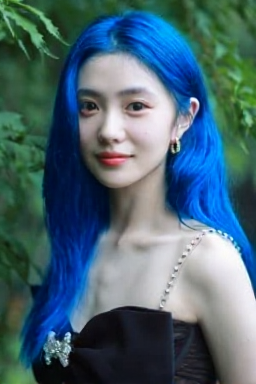

In [13]:
results[0]

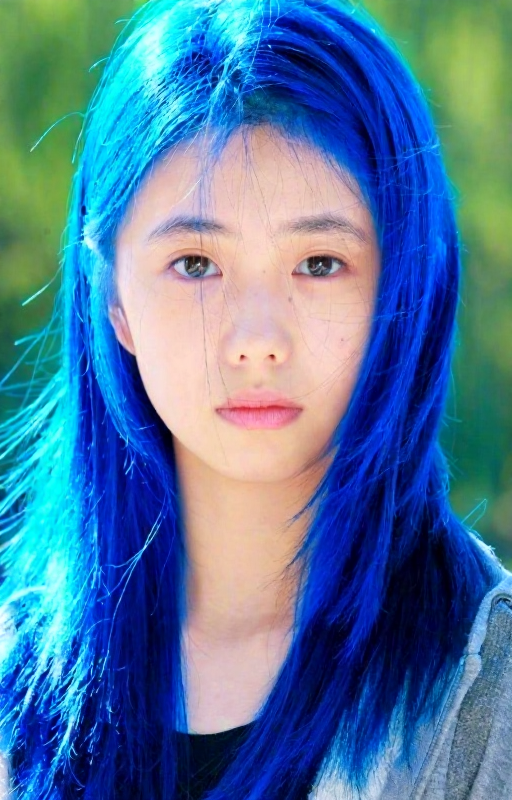

In [14]:
results[1]

## 5. Display Results


## 6. Visual Comparison


In [15]:
# Load and display comparison images
comparison_dir = results['output_dir']
comparison_files = glob.glob(os.path.join(comparison_dir, "comparison_sample_*.png"))

if comparison_files:
    print(f"Found {len(comparison_files)} comparison images")

    # Display each comparison
    for i, comp_file in enumerate(sorted(comparison_files)):
        img = Image.open(comp_file)
        plt.figure(figsize=(15, 10))
        plt.imshow(img)
        plt.title(f"Comparison for Sample {i+1}")
        plt.axis('off')
        plt.show()
else:
    print("No comparison images found")


TypeError: list indices must be integers or slices, not str